# <center> Plummer Sphere

In [3]:
import numpy as np
import scipy
import math
import random
import pandas as pd
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import os
import time
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D

#plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['font.size'] = 15

#config plot
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
%config InlineBackend.figure_format='retina'

In [4]:
import matplotlib as matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

We started this simulation by initializating the particle positions following a Plummer sphere. We set the number of particles equal to $10^4$ and arbitrarly choose to set the total mass equal to 100 internal units.

In [5]:
N     =  3*10**4
M_tot =  1
b     =  10
m = np.ones(N)*M_tot/N

# <center> Description of the model

Density distribution of a Plummer sphere:


$$\rho(r)=\frac{3M_{tot}}{4\pi b^3}\frac{1}{(1+\frac{r^2}{b^2})^{5/2}}$$


Mass of a Plummer sphere:


$$M(r)=\int_0^r4\pi r'^2\rho(r')dr'=\frac{M_{tot}r^3}{b^3(1+\frac{r^2}{b^2})^{3/2}}=\frac{M_{tot}r^3}{(r^2+b^2)^{3/2}}$$


Radius of the Plummer sphere obtained by inverting the mass formula:


$$r = \left[\left(\frac{M(r)}{M_{tot}}\right)^{-2/3}-1\right]^{-1/2}\cdot b$$

We, then, computed the dynamical time from the density at the scale parameter b.

$$T_{dyn} = \sqrt{\frac{32}{3\pi\rho(b)}}$$

In [6]:
rho   = (3*M_tot)/(4*np.pi*b**3*2**(5/2))
t_dyn = (32/(3*np.pi*rho))**(1/2)
print(t_dyn)

283.6424478370661


We found out that the dynamical time is equal to:$$T_{dyn} = \sqrt{\frac{32}{3\pi\rho(b)}}= 10.03$$ 

# <center> Distribution of the plummer sphere with Monte Carlo method

Initially, we defined the parameters: $\phi$, $\theta$ and the radius, we then plotted their distributions in three graphs.

In [7]:
#Definition of the parameters we need in order to compute the MC method
#Phi
phi       = np.random.uniform(0,2*np.pi,N)
#Theta
arc_theta = np.random.uniform(0,1,N)
theta     = np.asarray([math.acos(1-2*arc_theta[i]) for i in range(N)])
#Radius
cdf       = np.random.uniform(0,1,N) #cdf = M(R)/M_tot
r         = (cdf**(-2/3)-1)**(-0.5)*b

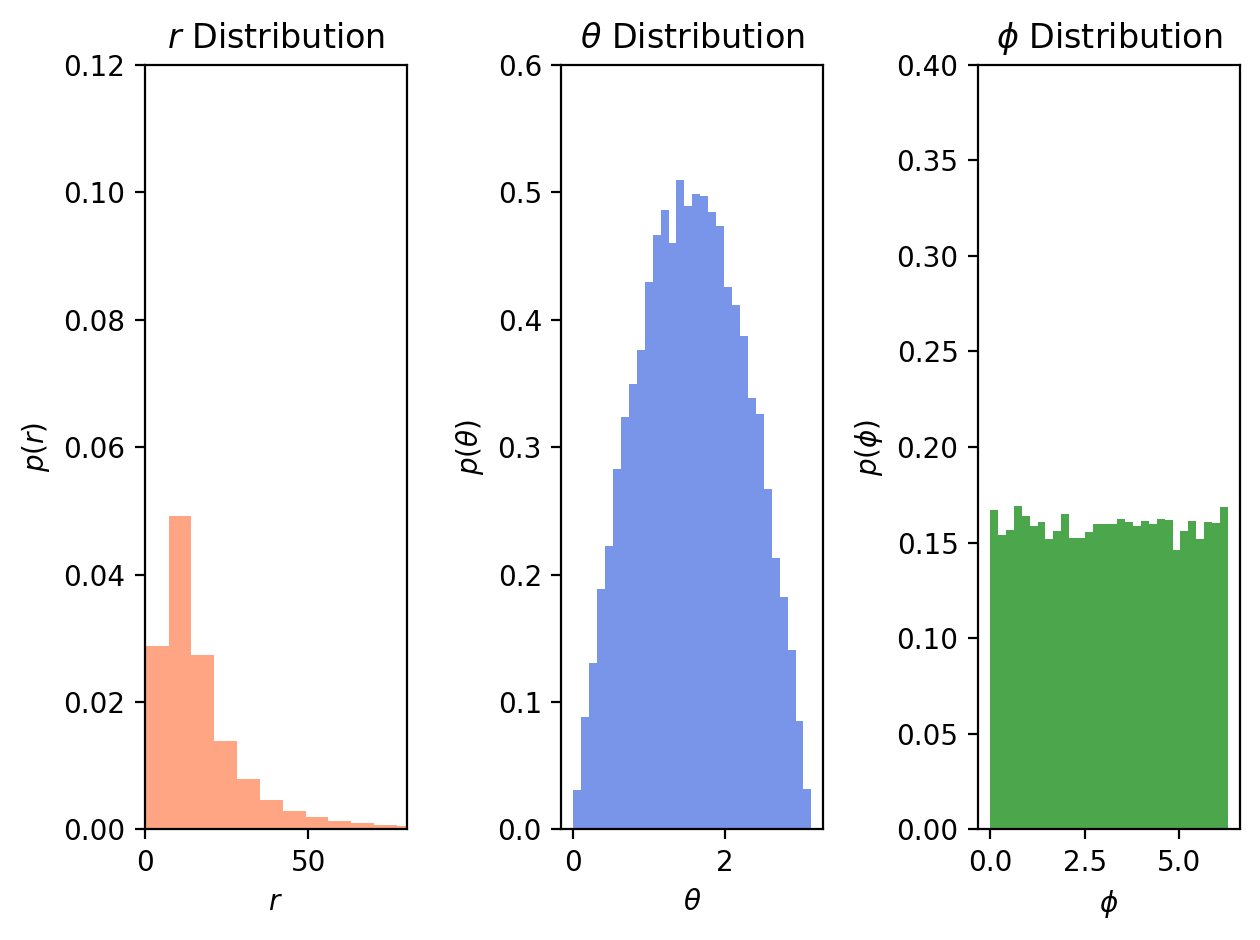

In [15]:
#Distribution of the three parameters in histograms
fig, ax = plt.subplots(1,3, tight_layout=True) 

ax[0].hist(r, bins = 800, color = 'coral', density=True, alpha=.7, lw=0) 
ax[0].set(xlim=(0,80), ylim = (0,0.12), title = fr'$r$ Distribution', xlabel = r'$r$', ylabel=r'$p(r)$') 

ax[1].hist(theta, bins = 30, color = 'royalblue', density=True, alpha=.7, lw=0)
ax[1].set(ylim = (0,0.6), title = fr'$\theta$ Distribution', xlabel = r'$\theta$', ylabel=r'$p(\theta)$')

ax[2].hist(phi, bins = 30, color = 'green', density=True, alpha=.7, lw=0)
ax[2].set(ylim = (0,0.4), title = fr'$\phi$ Distribution', xlabel = r'$\phi$', ylabel=r'$p(\phi)$')
plt.show()

Write the parameters positions in cartesian coordinates.

In [16]:
X=r*np.sin(theta)*np.cos(phi)
Y=r*np.sin(theta)*np.sin(phi)
Z=r*np.cos(theta)

In [17]:
cm_x_i = np.sum(X)/N
cm_y_i = np.sum(Y)/N
cm_z_i = np.sum(Z)/N

# <center> 3D Distribution of the Plummer Sphere

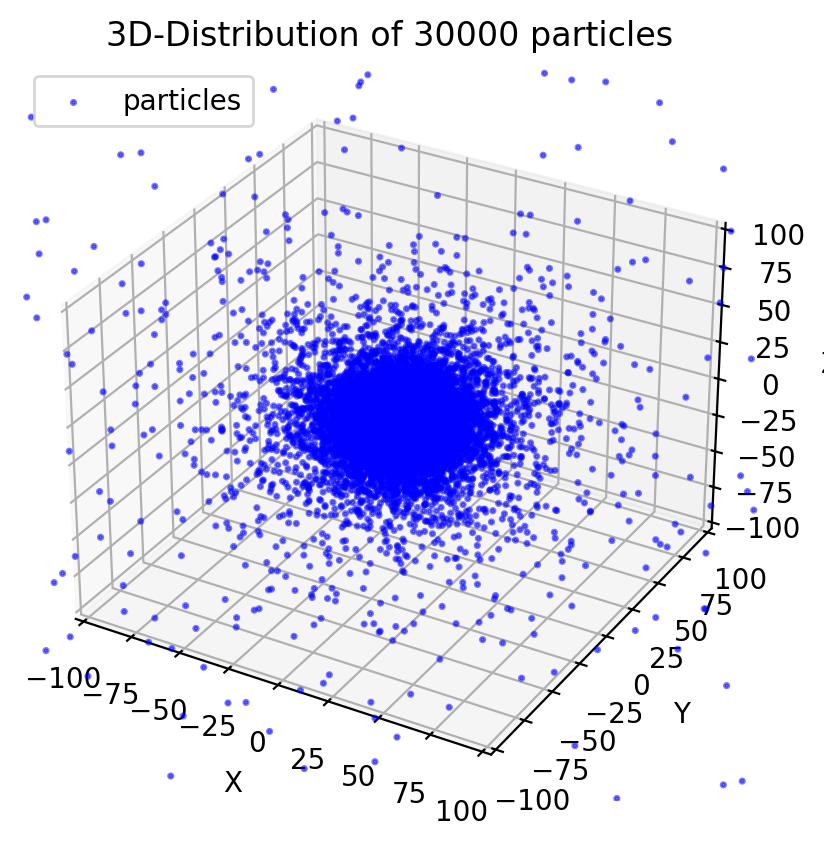

In [18]:
fig = plt.figure()
ax  = plt.axes(projection='3d')
ax.scatter3D(X,Y,Z,s=2.5, color='blue',alpha=0.5, label='particles')
ax.set(xlim=(-100,100), ylim = (-100,100), zlim = (-100,100))
ax.set(title = fr'3D-Distribution of {N} particles', xlabel = r'X', ylabel = r'Y', zlabel = r'Z')
plt.legend()
plt.show()

# <center> Monte-Carlo rejection method


From the radius distribution we can get the formula of the potential, from which we can derive the escape velocity. Starting from the cumulative function:

$$F(\epsilon) = \int_{0}^{\epsilon} f(\epsilon)d^3v$$

and assuming that the field is isotropic, we then redifined the velocity as:

$$q= \frac{v}{\sqrt{2\psi}}$$ 

and we got: 

$$F(\epsilon) \propto \int_{0}^{1} (1-q^2)^{7/2}q^2 dq$$

We are unable to invert this equation, so in order to compute a cumulative function, and so an inverse function, we used the Monte-Carlo rejection method.

We wanted to sample:

$$f(\bar{x})\rightarrow g(x) : g(x) > f(x)  \forall x \rightarrow G(x) \rightarrow F(x) $$

Where g(x) is an arbitrary function in order to compute the comulative and the inverse. 

We set: $$y = (1-q^2)^{7/2}q^2$$

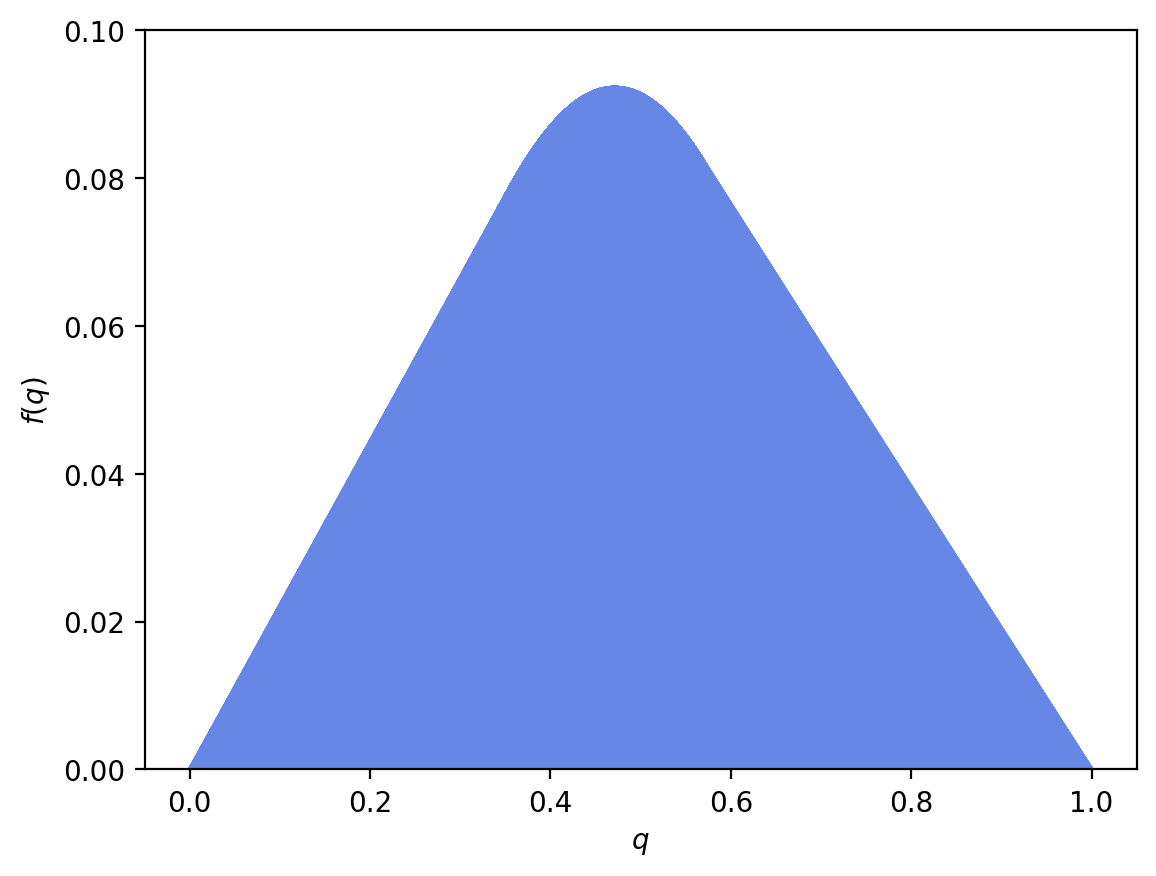

In [19]:
ax = plt.subplot()
q = np.random.uniform(0,1,N)
y = (1-q**2)**(7/2)*q**2
ax.plot(q,y, color='royalblue', alpha = .8)
ax.set(ylim = (0,0.1), xlabel = r'$q$', ylabel = r'$f(q)$')
plt.show()

In [20]:
#Definition of the function for the Monte-Carlo rejection method
def inverse_mc (y):
    g = np.max(y)
    #extract G from 0-g at random
    G = np.random.uniform(0,g)
    #compute the q associated (divided by g to normalize to 1(?))
    q_test = G/g
    #extract h from 0-g at random
    a = (1-q_test**2)**(7/2)*q_test**2
    h = np.random.uniform(0,g)
    #see if reject this or not
    if (h<=a):
        return q_test
    else:
        return -1

In [21]:
Q=np.array([])
while (len (Q)<N):
    temp = inverse_mc(y)
    if (temp!=(-1)):
        Q = np.append(Q,temp)

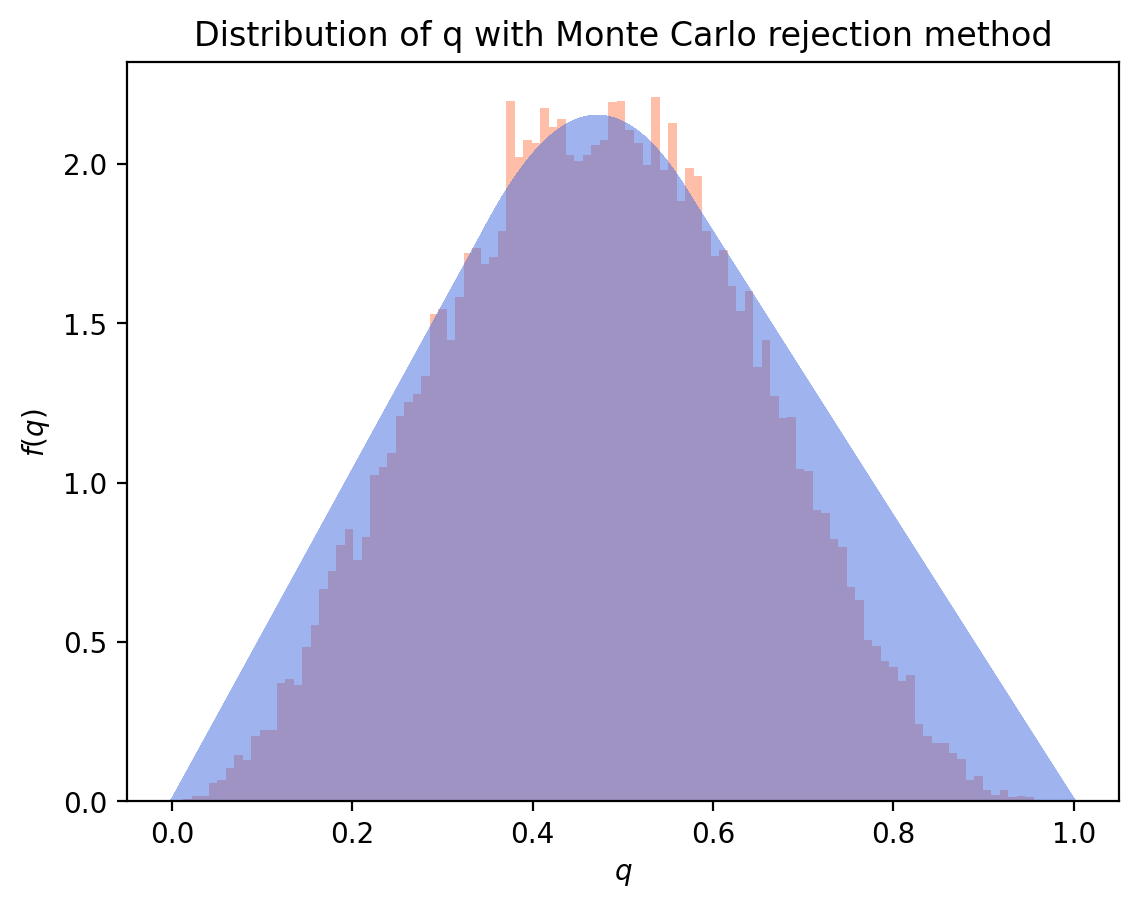

In [22]:
ax = plt.subplot()
ax.plot(q,512*y/(7*np.pi), color='royalblue', alpha = .5)
ax.hist(Q, density = True, alpha = .5, bins = 100, color = 'coral', lw = .2)
ax.set(title = 'Distribution of q with Monte Carlo rejection method', xlabel = 'q', ylabel = 'y')
ax.set(xlabel = r'$q$', ylabel = r'$f(q)$')
plt.show()

Once we found the inverse function through the Monte-Carlo rejection method, we computed the escape velocity.
The potential for the Plummer sphere is:

$$\phi=\frac{-GM_{tot}}{\sqrt{r^2+b^2}}$$

The relative potential is:
$$\psi=-\phi+\phi_0=-\phi$$
We defined $\phi_0$ as a constant.

The escape velocity is:
$$v_{escape}=\sqrt{2\psi}\cdot q$$

In [23]:
#Definition of Phi (relative potential)
Phi   = +M_tot/((r**2+b**2)**(1/2))

#Escape velocity in modulus
v_esc = (2*Phi)**(1/2)*Q
#phi
phi       = np.random.uniform(0,2*np.pi,N)
#theta
arc_theta = np.random.uniform(0,1,N)
theta     = np.asarray([math.acos(1-2*arc_theta[i]) for i in range(N)])

In [24]:
v_x = v_esc*np.sin(theta)*np.cos(phi)
v_y = v_esc*np.sin(theta)*np.sin(phi)
v_z = v_esc*np.cos(theta)

# <center> Simulation

In [25]:
np.savetxt('masses.txt', m)
np.savetxt('positions.txt',np.column_stack((X,Y,Z)))
np.savetxt('velocities.txt', np.column_stack((v_x,v_y,v_z)))

with open('initial_data_plummer1.txt', 'w+') as file:
    file.write(repr(N)+'\n3\n0\n')
    file.write(open('masses.txt','r').read()+open('positions.txt','r').read()+open('velocities.txt','r').read())

In [26]:
%%timeit
open('plummer_equilibrium1.txt', 'w').close()
tstop = 3*t_dyn
dtime = 0.1
eps   = 0.03
theta_ = 0.1
dtout = 5
os.system('./treecode in=initial_data_plummer1.txt tstop='+ str(tstop) +' dtime='+ str(dtime) +'eps='+str(eps)+'theta='+str(theta_)+' dtout='+ str(dtout) +' out=plummer_equilibrium1.txt > logoutput_plummer1.txt')

The slowest run took 1954.51 times longer than the fastest. This could mean that an intermediate result is being cached.
46.7 s ± 1min 48s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
#read the data
data = pd.read_csv("plummer_equilibrium.txt", names=list(range(7)), sep = ' ')

In [28]:
def shrinking_sphere (x, y, z, N, min_particles):
    
    #Compute the initial center of mass
    cm_x = np.sum(x)/N
    cm_y = np.sum(y)/N
    cm_z = np.sum(z)/N
    
    cm = [((cm_x)**2+(cm_y)**2+(cm_z)**2)**0.5]
    counts = [0]
    i = 0
    
    cmx = []
    cmy = []
    cmz = []
    
    #Radii respect to the 1st cm
    rmax = np.max(((x-cm_x)**2 + (y-cm_y)**2 + (z-cm_z)**2)**0.5) * 0.975
    
    
    density_ = []
    raggi = np.linspace(0,rmax,1000)    
    
    while True:
        
        #Compute the distances from the new center of mass
        x_temp = x - cm_x
        y_temp = y - cm_y
        z_temp = z - cm_z
        r_temp = (x_temp**2+y_temp**2+z_temp**2)**0.5
        
        #Take only the distances below the previous sphere radius reduced by 2.5%
        mask   = r_temp < rmax
           
        #Low number of particles leads to have an inaccurate cm 
        #We stop before this
        if np.sum(mask) < min_particles:
            break
            
        #Compute the new center of mass
        cm_x_temp = np.sum(x[mask])/len(x[mask])
        cm_y_temp = np.sum(y[mask])/len(x[mask])
        cm_z_temp = np.sum(z[mask])/len(x[mask])
        
        #Check if the center of mass has converged
        #if (len(x[mask])<1000):
        #    break
        
        if (np.allclose(cm_x,cm_x_temp) & np.allclose(cm_y,cm_y_temp) & np.allclose(cm_z,cm_z_temp)):
            break
        
        #if (cm[i]<cm[i-1]*0.01):
        #    break
        
        #Otherwise reset the center of mass
        cm_x = cm_x_temp
        cm_y = cm_y_temp
        cm_z = cm_z_temp
        cmx.append(cm_x)
        cmy.append(cm_y)
        cmz.append(cm_z)
        
        i += 1
        counts.append(i)
        cm.append(((cm_x)**2+(cm_y)**2+(cm_z)**2)**0.5)
        
        #Set the new radius
        rmax = np.max(((x[mask]-cm_x)**2 + (y[mask]-cm_y)**2 + (z[mask]-cm_z)**2)**0.5) * 0.975
        
        #rmax1= rmax*0.975
        #rmax = np.max(r_temp[mask])*0.8
        #print('rmax',rmax,'i',i,'n',len(x[mask]))
        print('i',i,'n',len(x[mask]))
        
    '''
        delta_V = np.array([4*np.pi*raggi[i+1]**3/3 - 4*np.pi*raggi[i]**3/3 for i in range(len(raggi)-1)])

        #Function to get the number of particles inside each shell at a fixed time
        def number_particles(raggi, r_temp):
            num_part = []
            for i in range(len(raggi)-1):
                left = raggi[i]
                right = raggi[i+1]
                provv = len([el for el in (r_temp) if (left<el<right)])
                num_part.append(provv)
            return num_part

        #Compute the density profile
        density_.append(np.array((number_particles(raggi,r_temp)/delta_V)*M_tot/N))


    for density in density_:
        plt.plot(raggi[:-1], density)
    plt.loglog()
    plt.show()
    '''
    plt.plot(counts,cm)
    plt.xlabel('Iteration')
    plt.ylabel('CM')
    plt.show()
    
    return cm_x, cm_y, cm_z, cmx, cmy, cmz

In [29]:
def dati (data,N, shrinking = False):
    
    x = []
    y = []
    z = []
    
    start = N + 3
    step  = N * 3 + 3
    
    a = (np.array([data.iloc[i::step,:].copy() for i in range(start,start+N)]))
    for j in range(len(a)):
        temp = np.array([a[j][i][~np.isnan(a[j][i])] for i in range(len(a[j]))])
        
        x.append(temp[:,0])
        y.append(temp[:,1])
        z.append(temp[:,2])
     
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    
    cm_x = []
    cm_y = []
    cm_z = []
    
    #Set the threshold as the 15% of the total number of particles
    #why 20? by eye after that the cm changes a lot
    min_particles = 0.20 * N
    for i in range (len(x[0])):
        if (shrinking == True):
            cm_x_, cm_y_, cm_z_, cmx, cmy, cmz = shrinking_sphere(x[:,i],y[:,i],z[:,i],N,min_particles)
            cm_x.append(np.mean(cmx[-60:]))
            cm_y.append(np.mean(cmy[-60:]))
            cm_z.append(np.mean(cmz[-60:]))
        else:
            cm_x.append(np.sum(x.T[i])/N)
            cm_y.append(np.sum(y.T[i])/N)
            cm_z.append(np.sum(z.T[i])/N)
       
    #print('The final center of mass is (', cm_x[len(x[0])-1],', ', cm_y[len(x[0])-1],', ', cm_z[len(x[0])-1], ')')
    
    x = x - cm_x
    y = y - cm_y
    z = z - cm_z
    
    #r = np.array([(x[i]**2+y[i]**2+z[i]**2)**0.5 for i in range(N)])
    r =(x**2+y**2+z**2)**0.5
    
    t = (np.array(data.iloc[2::step,:].copy()))[:,2]
    
    return x,y,z,r,t,cm_x,cm_y,cm_z

Read the data. Positions are computed from the center of mass at each time, not from (0,0,0).

In [30]:
#print('The initial center of mass is (', cm_x_i,', ', cm_y_i,', ', cm_z_i, ')')
#x,y,z,r,time = dati(data, N, shrinking = False)

x,y,z,r,time,cm_x,cm_y,cm_z = dati(data, N, shrinking = False)

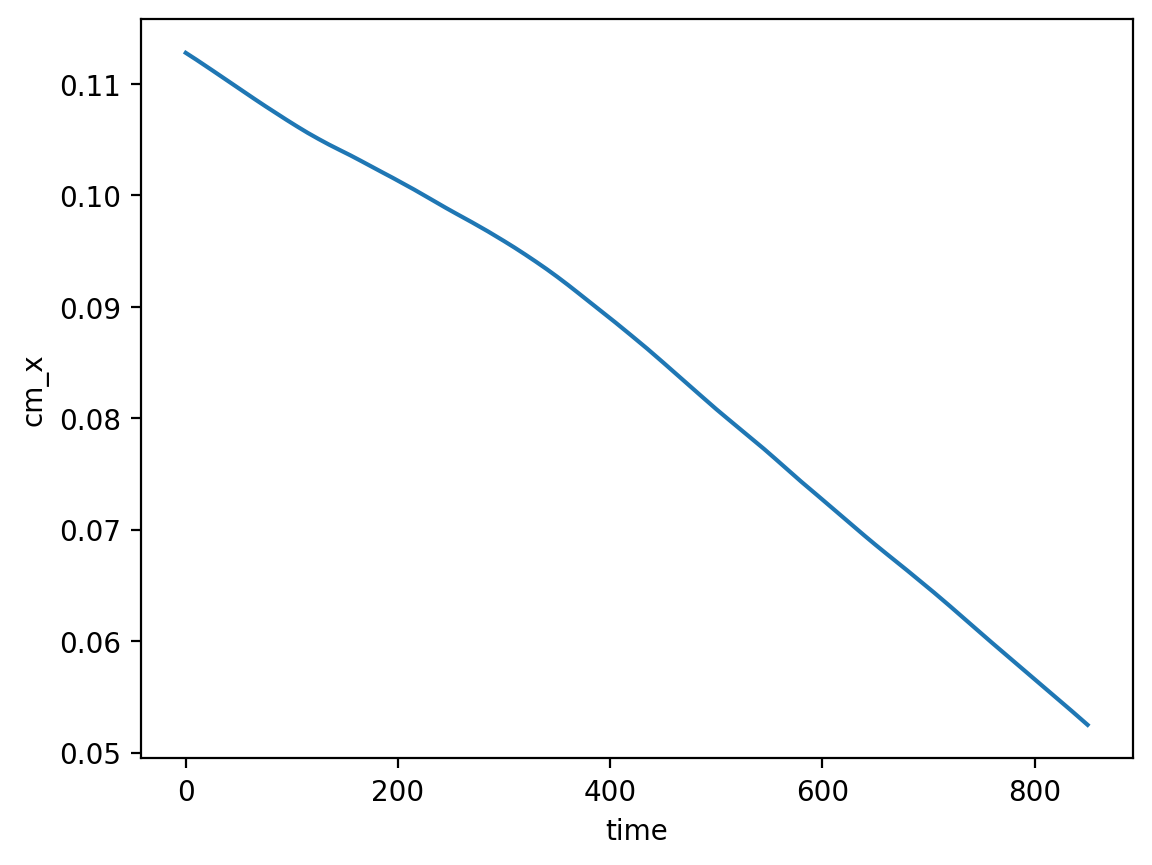

In [31]:
plt.plot(time,cm_x)
plt.xlabel('time')
plt.ylabel('cm_x')
plt.show()

In [ ]:
'''fig = plt.figure()
ax  = plt.axes(projection='3d')
ax.scatter3D(x[:,0],y[:,0],z[:,0],s=.5, color='blue',alpha=0.2, label='particles')
#ax.scatter3D(cm_x,cm_y,cm_z,s=1, color='red',alpha=1, label='cm')
ax.scatter3D(cm_x[0],cm_y[0],cm_z[0],s=10, color='black',alpha=0.5, label='cm initial')
ax.scatter3D(cm_x[-1],cm_y[-1],cm_z[-1],s=10, color='orange',alpha=1, label='cm final')
view=3
ax.set(xlim=(-view,view), ylim = (-view,view), zlim = (-view,view))
ax.set(title = fr'3D-Distribution of {N} particles', xlabel = r'X', ylabel = r'Y', zlabel = r'Z')
plt.legend()
plt.show()'''

# <center> Analysis of results

Initially, we checked if the center of mass changed from start to finish. We can observe that it slightly changes its positions.

We analyzed the density profile for each timestep, startig by computing the volume of 1000 shells between zero and the maximum position of the particles. We, then, set a function in order to get the number of particles inside the shells at a fixed time.
We computed the density profile for each timestep, we sampled the mean density profile and its error by estimating the error on the number of particles obtained by the simulation.
In the end we quantified the propagation of the error to the density and we plotted the result.

In [32]:
#Compute the volume of 1000 shells between 0 and the maximum position of the particles
raggi = np.linspace(0,np.max(r),1000)
delta_V = np.array([4*np.pi*raggi[i+1]**3/3 - 4*np.pi*raggi[i]**3/3 for i in range(len(raggi)-1)])

#Function to get the number of particles inside each shell at a fixed time
def number_particles(raggi, r, times):
    num_part = []
    for i in range(len(raggi)-1):
        left = raggi[i]
        right = raggi[i+1]
        provv = len([el for el in (r.T[int(times)]) if (left<el<right)])
        num_part.append(provv)
    return num_part
    
#Compute the density profile for each timestep
times = [0, int(len(r[0])/2), int(len(r[0])*3/4), len(r[0])-1]
density_ = np.array([(number_particles(raggi,r,times)/delta_V)*m[0] for times in times])

#Do the mean of the density profile in time
#density = np.mean(density_, axis = 0)

#Error on the number of particles by the simulation. Taken as the square root of the number of particles inside a shell.
error_N = np.array([np.sqrt(number_particles(raggi,r,times)) for times in times])
#Propagation of the error to the density
error_d = error_N * m[0] / delta_V


In order to compute the average number of particles inside each shell by using the analytical density distribution we applied the following equation:

$$<particles> = \int_{r_1}^{r_2}4\pi r^2 \rho(r) dr$$
Remind that the density profile of a Plummer sphere is:
$$\rho(r)=\frac{3M_{tot}}{4\pi b^3}\frac{1}{(1+\frac{r^2}{b^2})^{5/2}}$$
So the integral becomes
$$<particles> = \int_{r_1}^{r_2} \frac{3M_{tot}}{b^3} r^2 (1+\frac{r^2}{b^2})^{-5/2} dr = \frac{3M_{tot}}{b^3} \frac{r^3}{3(1+\frac{r^2}{b^2})^{3/2}}$$ evaluated between $r_1$ and $r_2$.
For each particle we took $1 \sigma$ as the error, since it is Poissonian we used the square root of the number of particles: $\sqrt{N}$. 
In the end we found the error propgation of the density

In [33]:
#Analitycal density profile
rho   = ((3*M_tot)/(4*np.pi*b**3))*(1/(1+(raggi**2/b**2))**(5/2))

#Function to compute the integral to get the number of particles
def integral (r,b):
    return r**3/(3*(1+r**2/b**2)**(3/2))

# p_integrale is the average number of particles in each shell predicted by the analytical solution
p_integrale = np.array([(integral(raggi[i+1],b) - integral(raggi[i],b))*(3*M_tot)/b**3 for i in range(len(raggi)-1)])

#We take 1 sigma as the error. Being Poissonian is the square root of the number of particles
error_p = np.sqrt(p_integrale)
#Error propagation on the density
error_d_t = error_p * m[0] / delta_V

In this graph we represented the analytic solution respect to the simulation in the logarothmic scale.

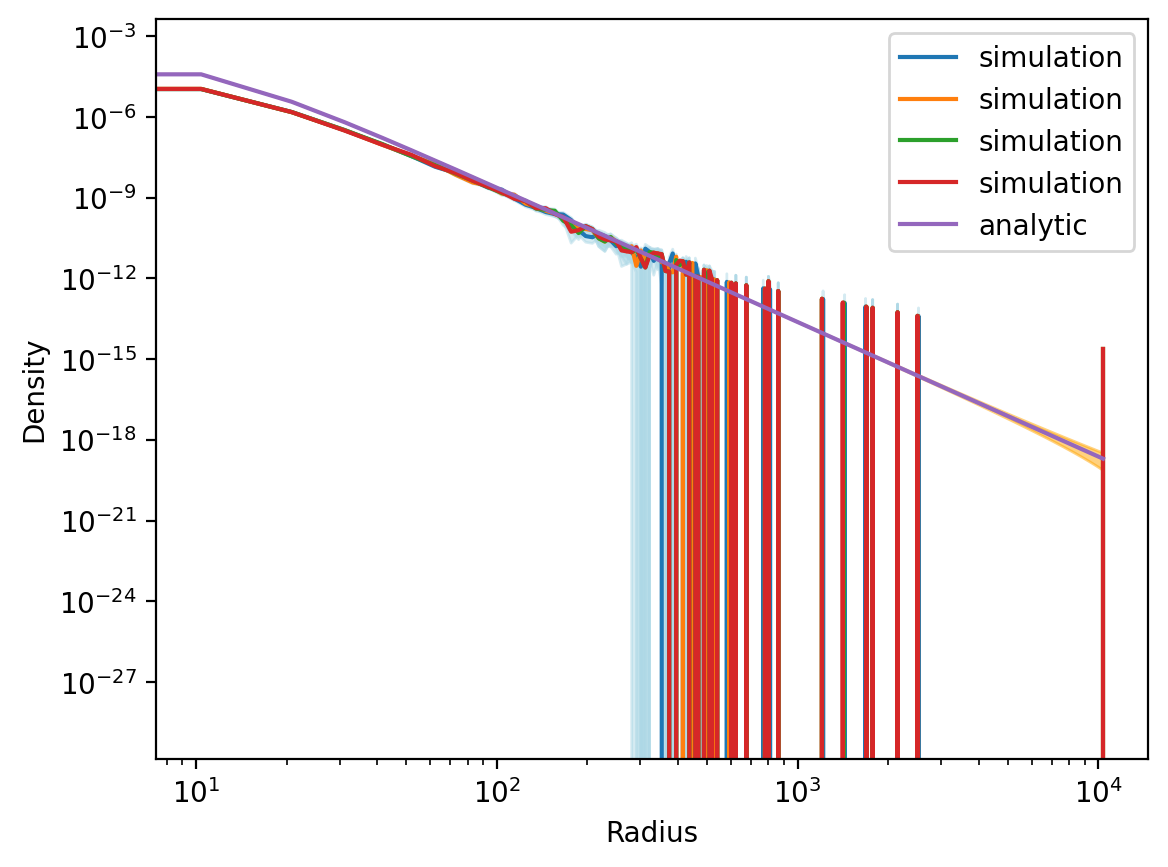

In [34]:
#Simulation
for density in density_:    
    plt.plot(raggi[:-1], density, label= 'simulation')
    plt.fill_between(raggi[:-1], density-error_d[0], density+error_d[0], alpha=0.5, color = 'lightblue')

#Analytic solution
plt.plot(raggi[:-1],rho[:-1], label='analytic')
plt.fill_between(raggi[:-1], rho[:-1]-error_d_t, rho[:-1]+error_d_t, alpha=0.5, color='orange')
plt.xlabel('Radius')
plt.ylabel('Density')
plt.loglog()
plt.legend()
plt.show()

In this graph we show a zoom in of the analytic solution respect to the simulation without the logarithmic scale.

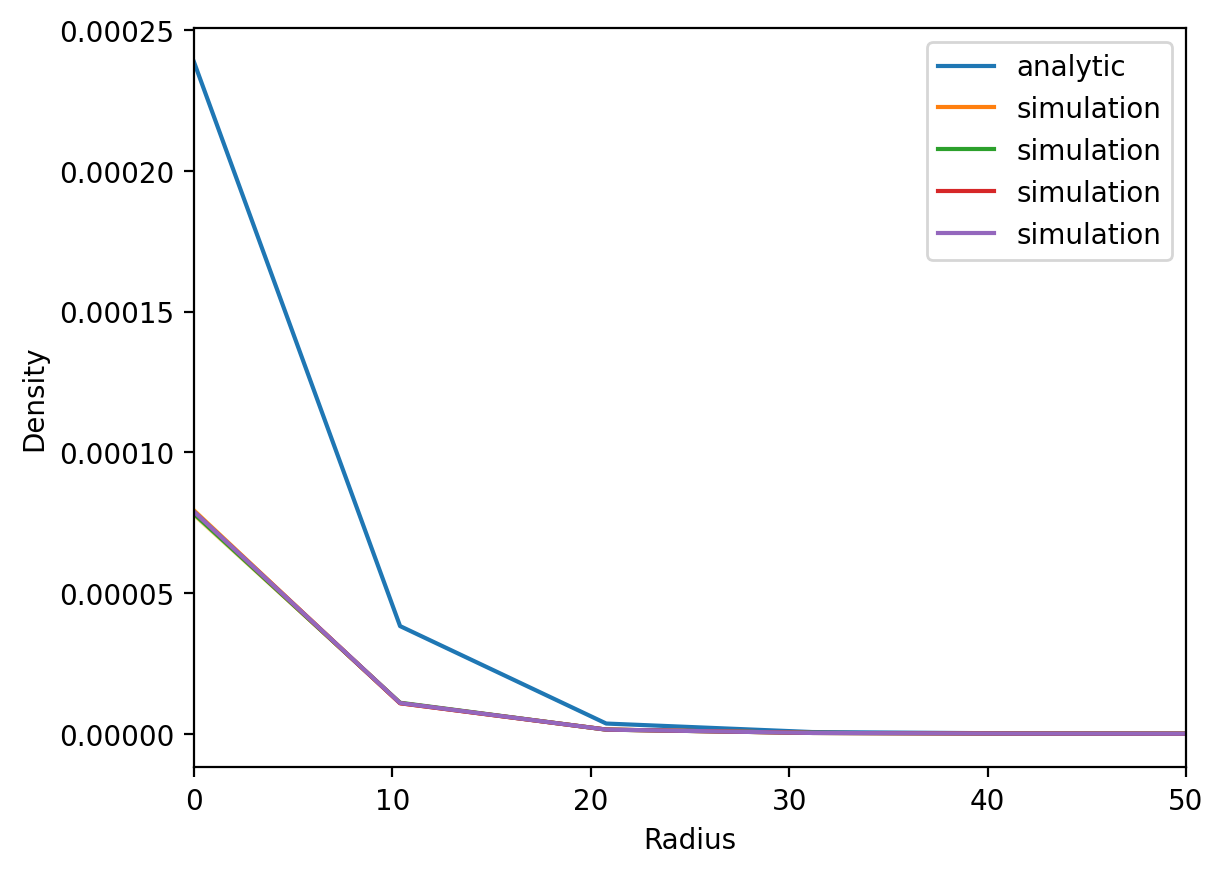

In [39]:
#Analytic solution
plt.plot(raggi[:-1],rho[:-1], label='analytic')
plt.fill_between(raggi[:-1], rho[:-1]-error_d_t, rho[:-1]+error_d_t, alpha=0.5, color='lightblue')

#Simulation
for density in density_:  
    plt.plot(raggi[:-1], density, label='simulation')
    plt.fill_between(raggi[:-1], density-error_d[0], density+error_d[0], alpha=0.5, color='orange')
plt.xlabel('Radius')
plt.ylabel('Density')
plt.xlim(0,50)
#plt.ylim(-0.030,0.02)
plt.legend()
plt.show()

After the analysis on the density profile we checked if we actually found the number of particles that we set as an initial condition ($10^4$).

In [40]:
#Check if we found actually all the particles
particles = number_particles(raggi,r,0)
print('Number of particles set as an initial condition:',N)
print('Number of particles we found through the simulation:',np.sum(particles))

Number of particles set as an initial condition: 30000
Number of particles we found through the simulation: 29999


Now we check if the radii are constant.

Text(0, 0.5, 'Radius')

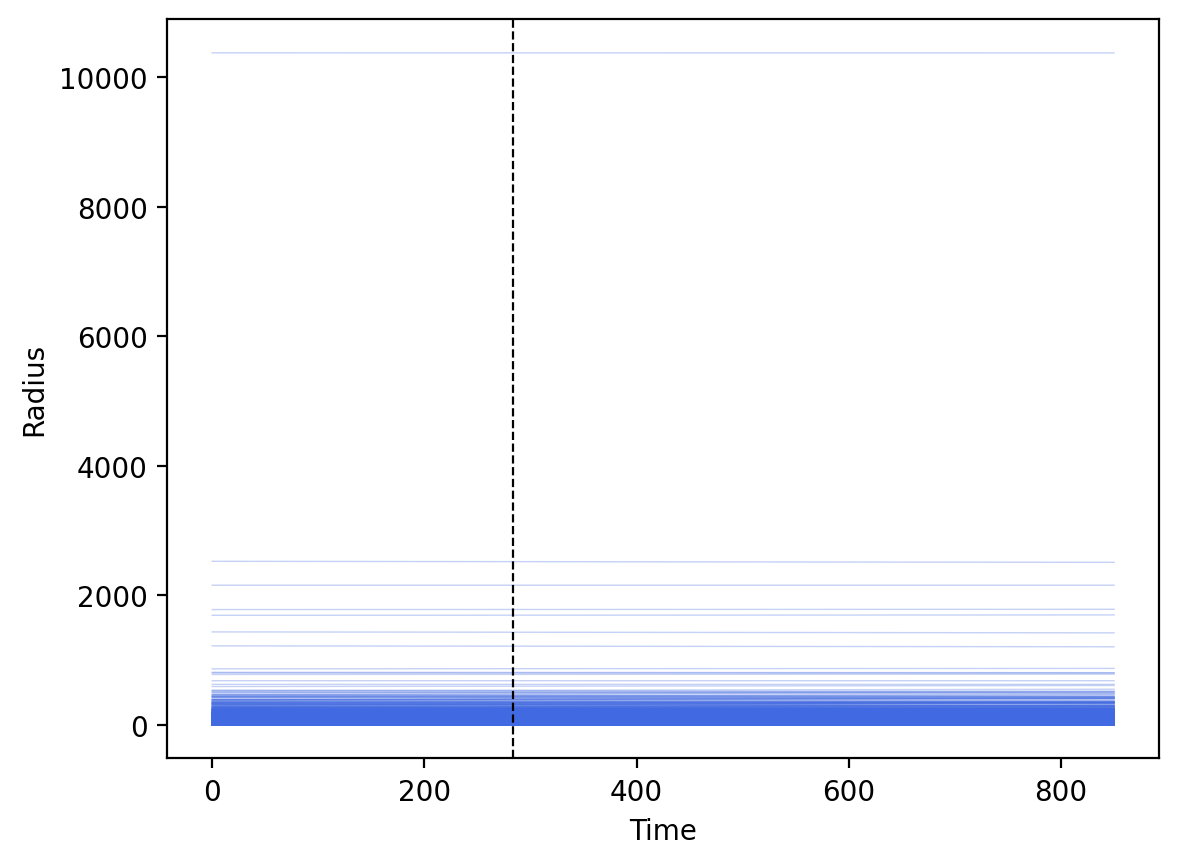

In [41]:
for i in range(len(r)):
    plt.plot(time,r[i,:], c='royalblue', alpha = .3, lw = .5);
G = 1

plt.axvline(t_dyn, color = 'black', ls = '--', lw = .8);
plt.xlabel('Time')
plt.ylabel('Radius')

By eye it seems that they are. We can check this statement by using the Lagrangian radii. 
We expect them to be constant.

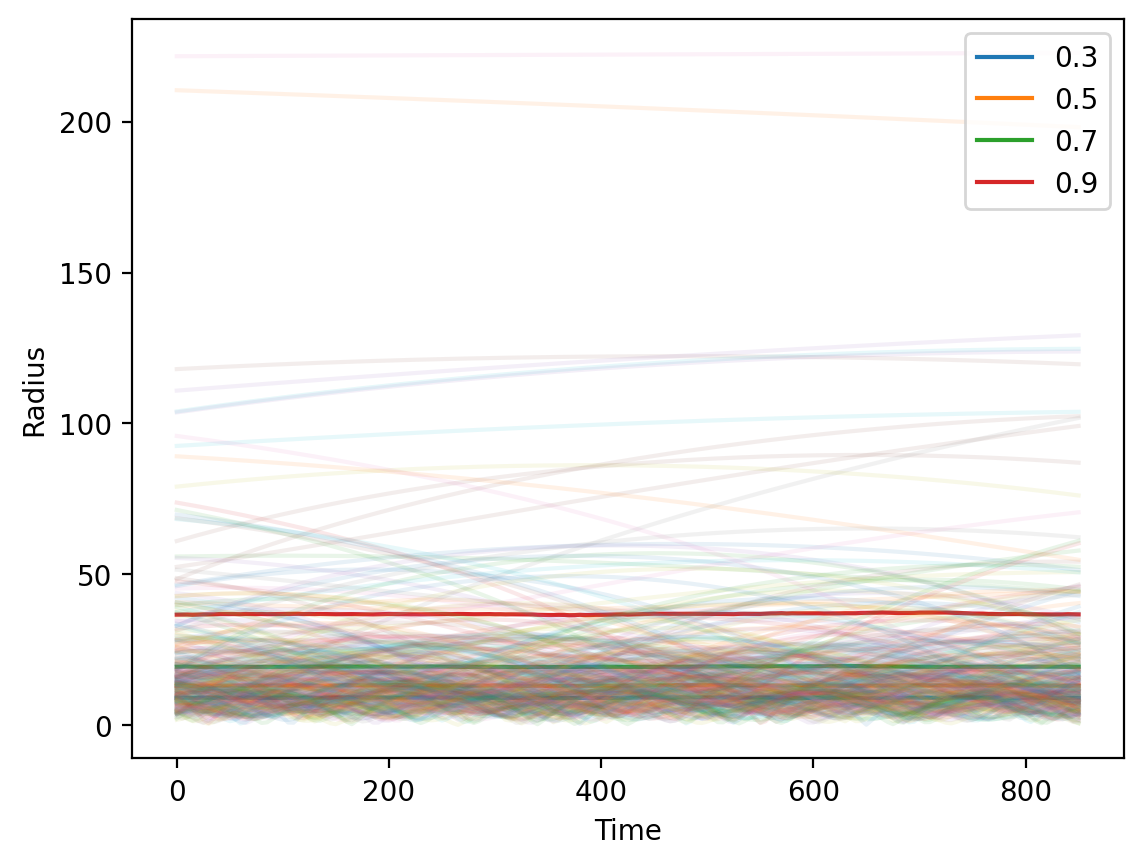

In [42]:
perc = [0.3,0.5,0.7,0.9]

for p in perc:
    r_L = []
    error = []
    for i in range(len(time)):
        a    = np.sort(r[:,i])
        mask = a<np.quantile(a,p)
        lagr    = (p**(-2/3)-1)**(-0.5)*b
        r_L.append(np.max(a[mask]))
        error.append(np.abs(lagr-np.max(a[mask]))/lagr)
    #Plot it
    r_L = np.array(r_L)
    error = np.array(error)
    plt.plot(time,r_L, label=str(p))
    plt.fill_between(time, r_L-error, r_L+error)


for i in range(0, N, 100):
    plt.plot(time,r[i], alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Radius')
plt.legend()
plt.show()

We can already observe that the radii are not constant. We further check the trend by plotting the Lagrangian Radius at 70% with its error respect the initial value at 70%.

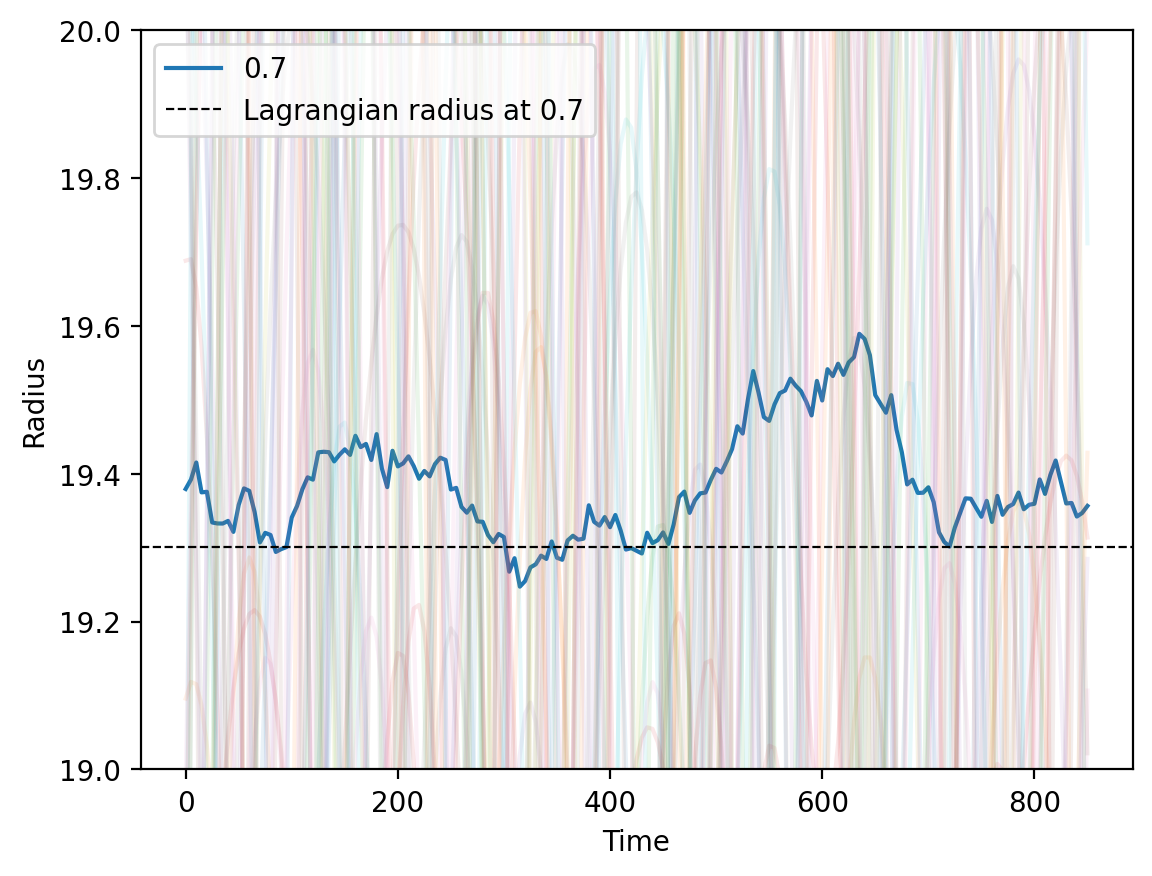

In [47]:
r_L = []
error = []
for i in range(len(time)):
    a    = np.sort(r[:,i])
    mask = a<np.quantile(a,0.7)
    lagr = (0.7**(-2/3)-1)**(-0.5)*b
    r_L.append(np.max(a[mask]))
    error.append(np.abs(lagr-np.max(a[mask]))/lagr)

#Plot the Lagrangian Radius with its error
r_L = np.array(r_L)
error = np.array(error)
plt.plot(time,r_L, label='0.7')
#plt.fill_between(time, r_L-error, r_L+error, color='lightblue')


for i in range(0, N, 100):
    plt.plot(time,r[i], alpha=0.1)

    
plt.axhline(lagr, color = 'black', ls = '--', lw = .8, label='Lagrangian radius at 0.7')
plt.ylim(19,20)
plt.xlabel('Time')
plt.ylabel('Radius')
plt.legend()
plt.show()

# <center> Animation of the Plummer Sphere 3D

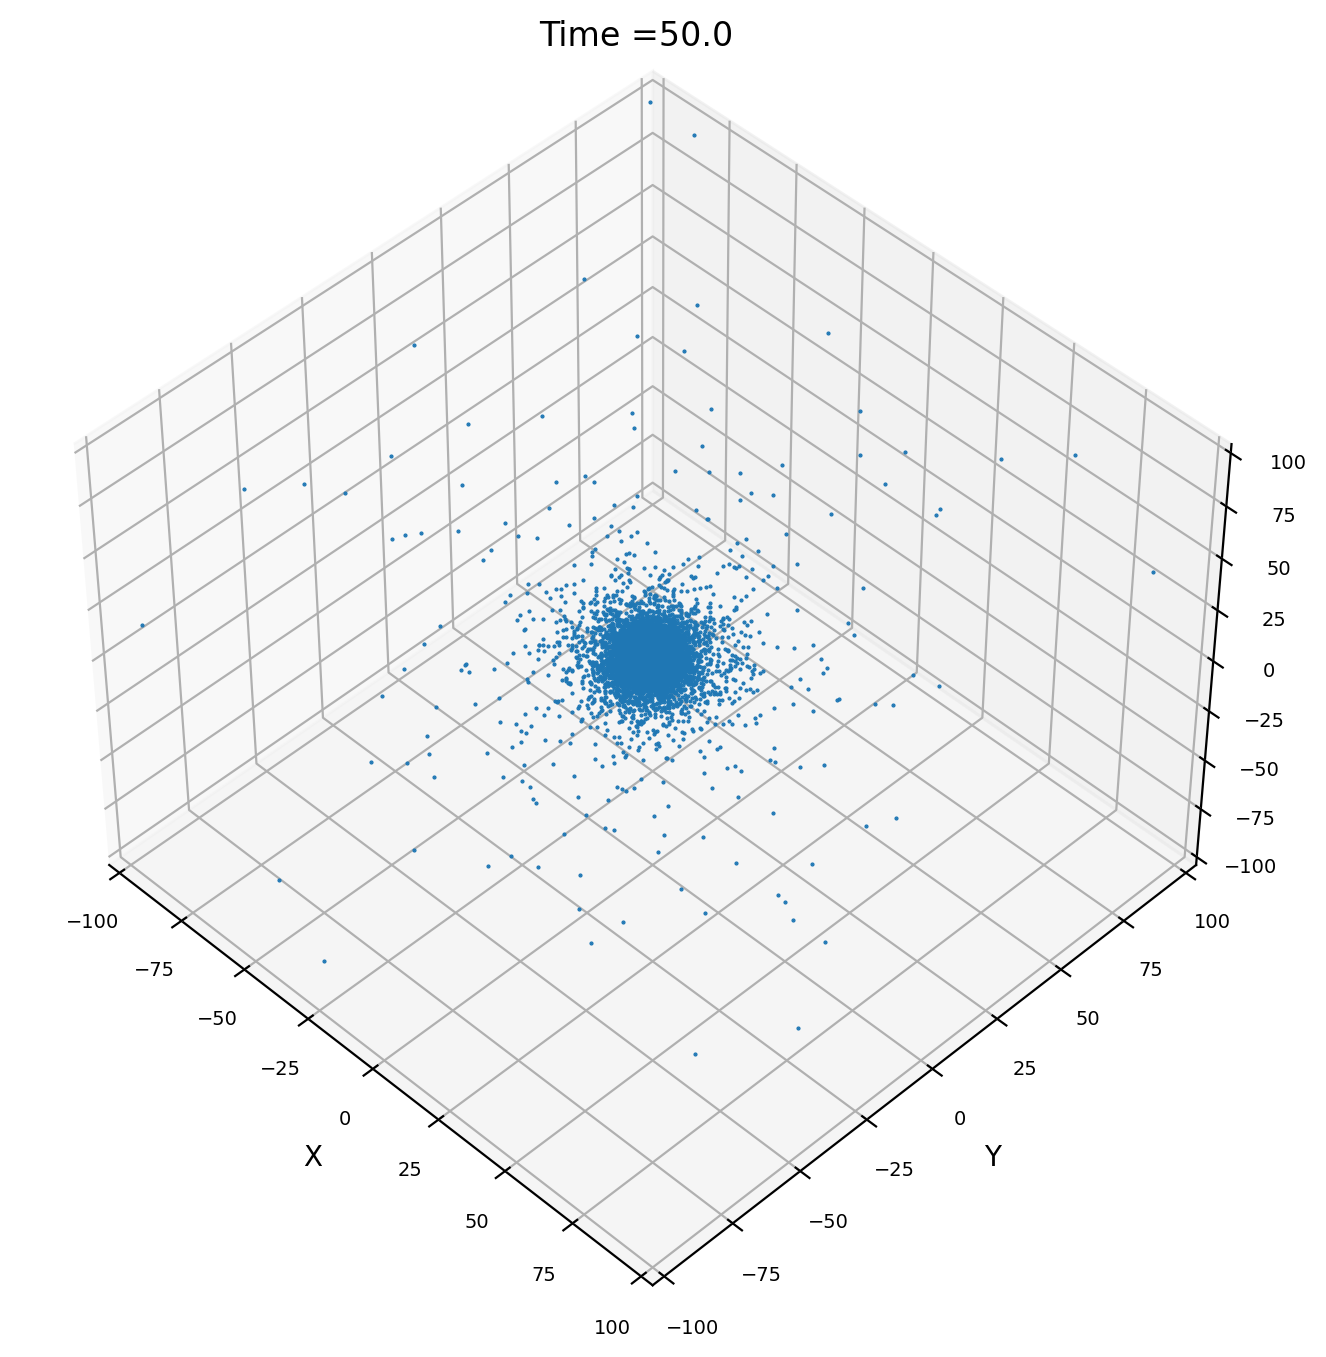

In [50]:
#plot------------------------------------------------------------------------------

fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(projection='3d')
ax.set_aspect('equal')

ax.view_init(elev=45, azim=-45)
ax.set_xlim(-100,+100)
ax.set_ylim(-100,+100)
ax.set_zlim(-100,+100)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='z', labelsize=7)


#animation--------------------------------------------------------------------------------
scatters, = ax.plot([], [], [], 'o', markersize='0.5')


def init():
    scatters.set_data([], [])
    scatters.set_3d_properties([])
    return scatters,

def animate_time(i): 
    scatters.set_data(x[:,i], y[:,i])
    scatters.set_3d_properties(z[:,i])
    ax.set_title('Time =' + str(np.round((np.array(time))[i])))
        
    return scatters,


num_frames = len(time)
animazione = FuncAnimation(fig, animate_time, frames=num_frames, interval=100, init_func=init)

animazione.save('plummer_equilibrium.gif', writer = 'ffmpeg')
plt.show()

plt.rcParams['animation.html'] = 'html5'
animazione